## Tarea 5 - IDS

Implementación completa de la Tarea 5 usando el dataset `heart_Tarea5.csv`. Este cuaderno realiza: carga de datos, limpieza, EDA, preprocesamiento mediante pipelines, búsqueda de hiperparámetros para Regresión Logística y k-NN, evaluación (métricas, ROC, matrices de confusión), ajuste de umbral, opción con SMOTE, interpretación de coeficientes y guardado del pipeline final.


In [27]:
# Imports y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)




In [28]:
# Cargar dataset y revisión inicial
DATA_PATH = 'heart_Tarea5.csv'

df = pd.read_csv(DATA_PATH)

print('Shape:', df.shape)
display(df.head())

print('\nColumnas y tipos:')
print(df.dtypes)

print('\nDescripción numérica:')
display(df.describe())

# Verificar columna target esperada
if 'HeartDisease' not in df.columns:
    raise ValueError("El archivo no contiene la columna 'HeartDisease' esperada. Columnas encontradas: {}".format(df.columns.tolist()))

print('\nDistribución de la variable objetivo (HeartDisease):')
print(df['HeartDisease'].value_counts(dropna=False))

# Duplicados
print('\nFilas duplicadas:', df.duplicated().sum())


Shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0



Columnas y tipos:
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Descripción numérica:


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



Distribución de la variable objetivo (HeartDisease):
HeartDisease
1    508
0    410
Name: count, dtype: int64

Filas duplicadas: 0


In [29]:
# Limpieza: tratar ceros no válidos como NA y revisar valores faltantes
# Columnas numéricas donde 0 no es fisiológicamente válido y probablemente indica missing
cols_zero_as_na = ['RestingBP', 'Cholesterol', 'MaxHR']

for c in cols_zero_as_na:
    if c in df.columns:
        n_zero = (df[c] == 0).sum()
        print(f"{c}: {n_zero} ceros (se reemplazarán por NaN)")
        df.loc[df[c] == 0, c] = np.nan

# Asegurarse de tipos categóricos
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for c in categorical_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Convertir target a 0/1 int si viene distinto
if df['HeartDisease'].dtype.name == 'category' or df['HeartDisease'].dtype == object:
    df['HeartDisease'] = df['HeartDisease'].astype(int)
else:
    df['HeartDisease'] = df['HeartDisease'].astype(int)

print('\nValores faltantes por columna:')
print(df.isna().sum())


RestingBP: 1 ceros (se reemplazarán por NaN)
Cholesterol: 172 ceros (se reemplazarán por NaN)
MaxHR: 0 ceros (se reemplazarán por NaN)

Valores faltantes por columna:
Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64


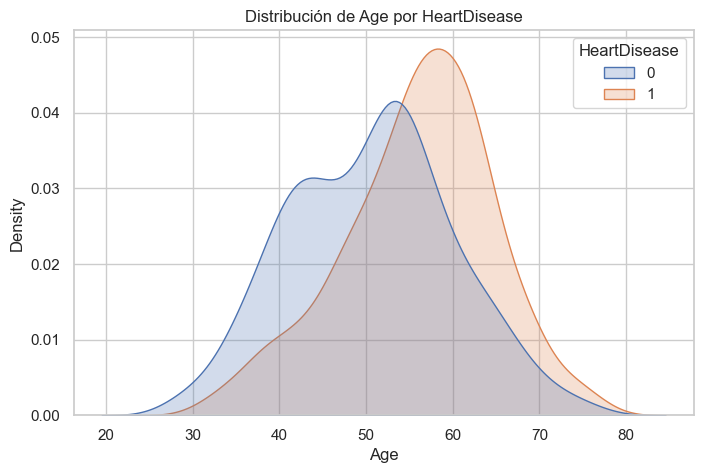

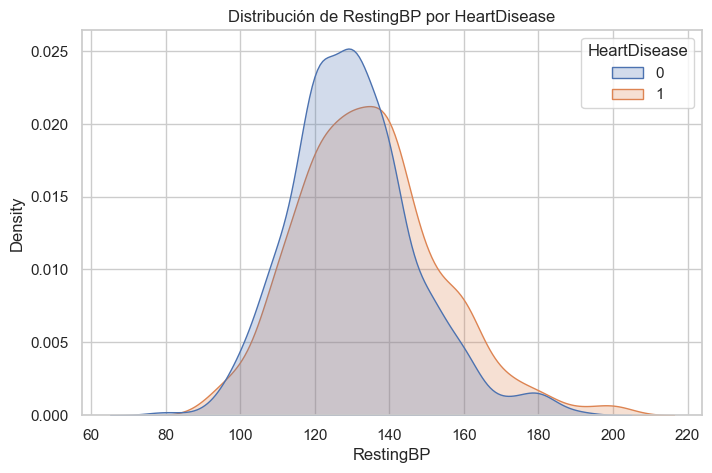

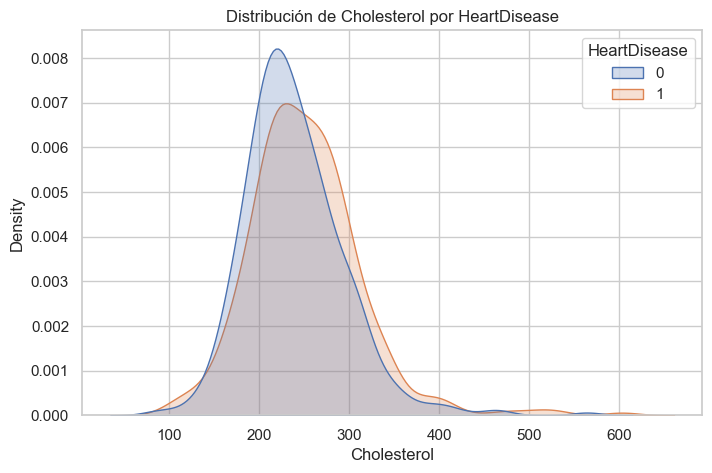

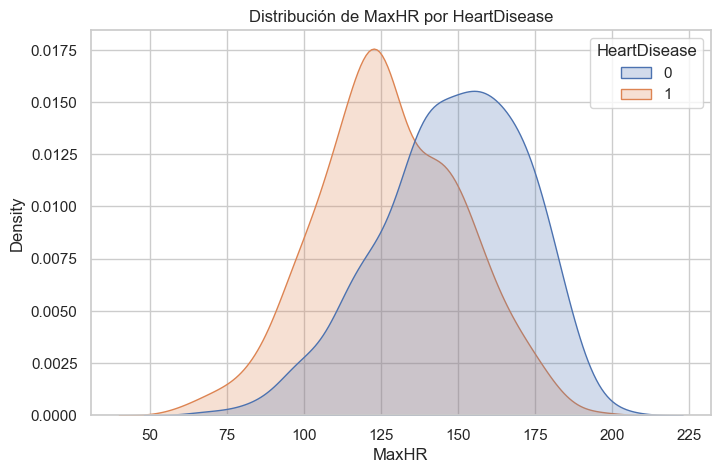

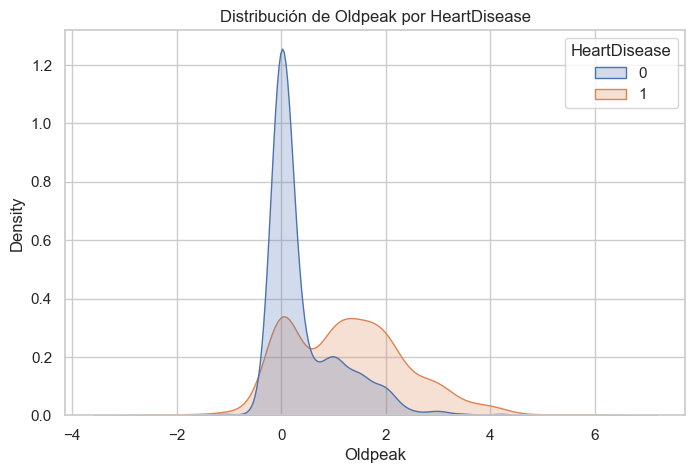

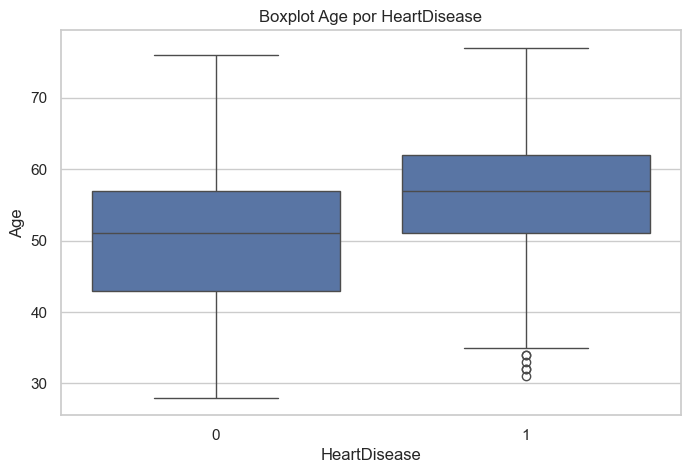

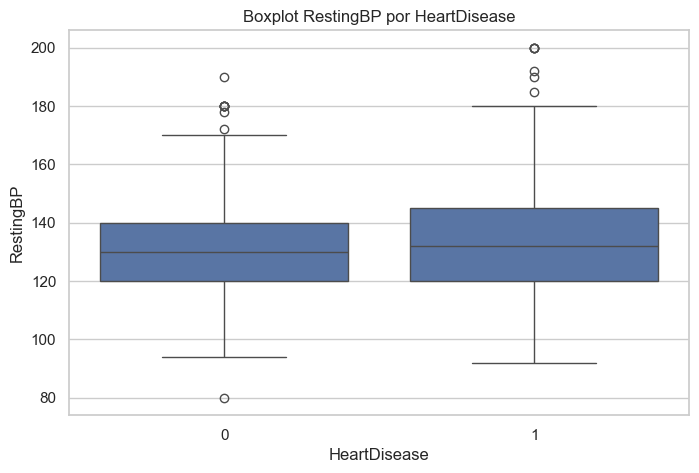

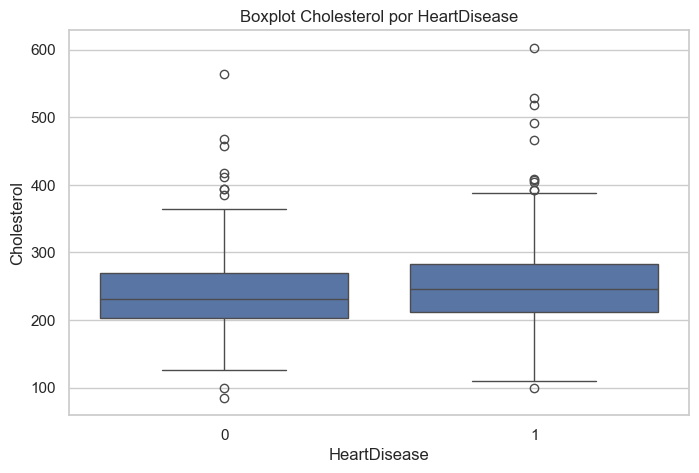

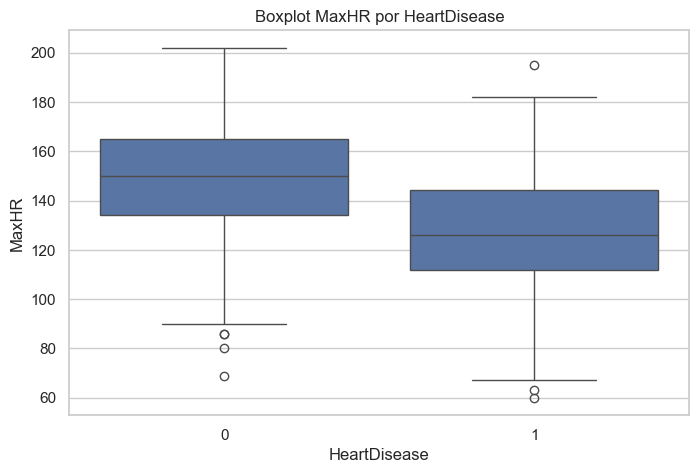

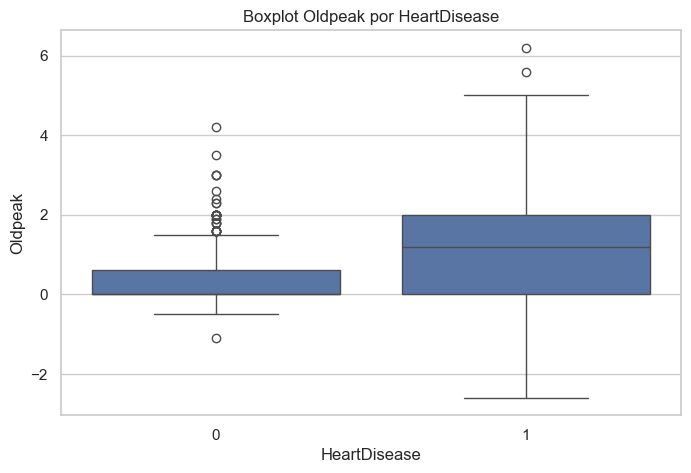

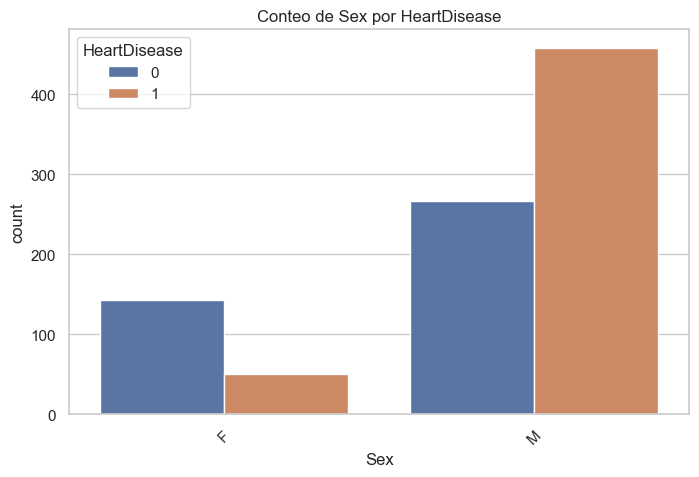

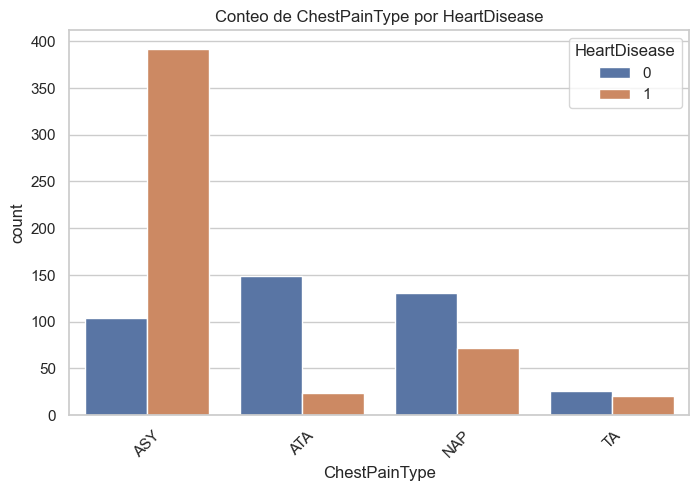

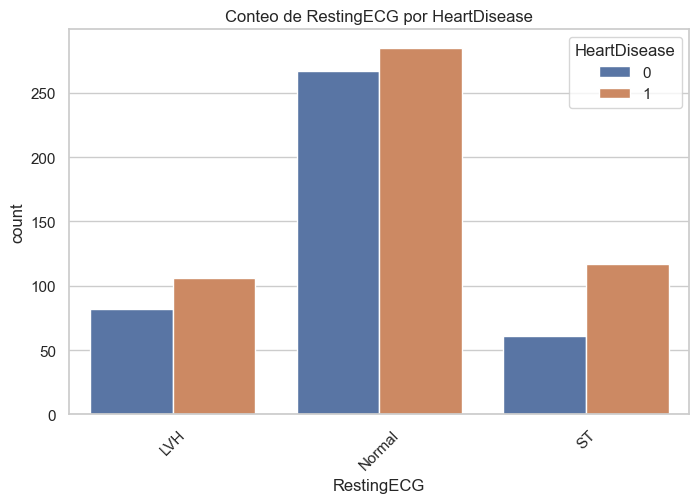

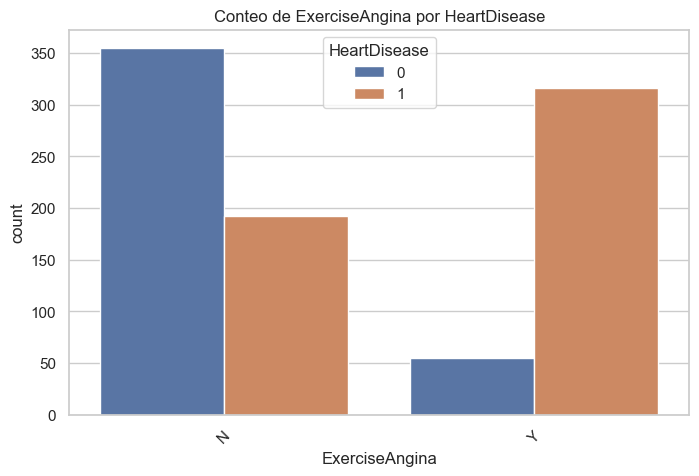

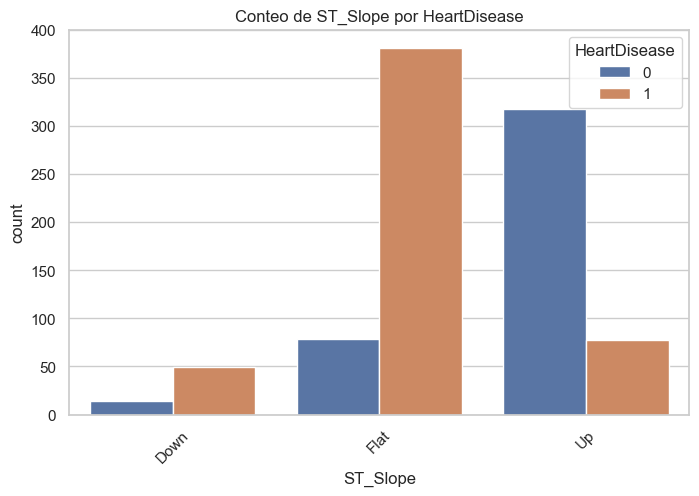

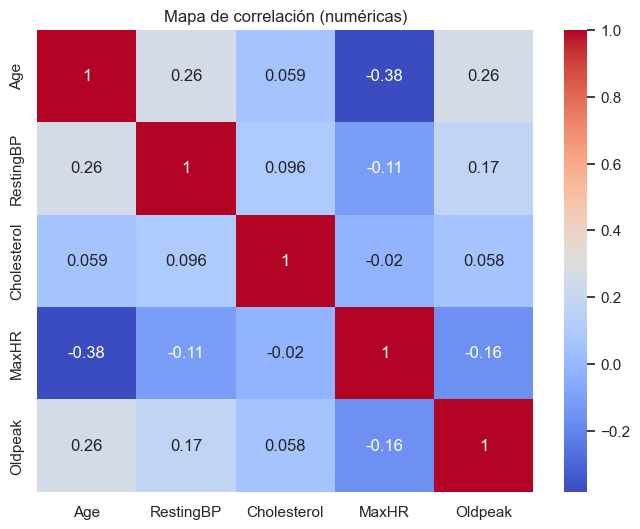

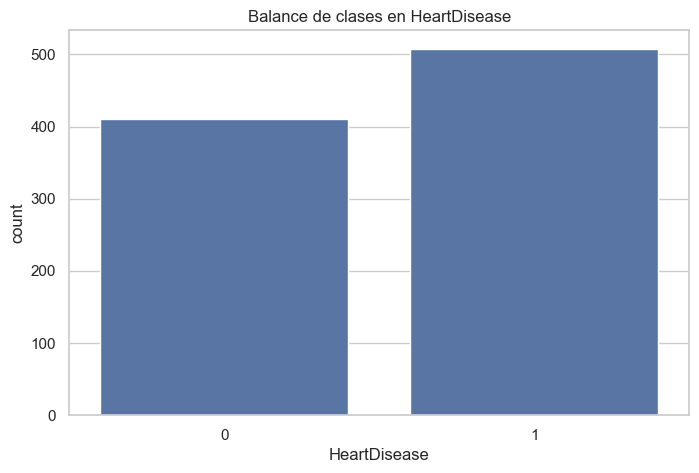


Proporciones:
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


In [30]:
# EDA: numéricos y categóricos
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
present_num = [c for c in num_features if c in df.columns]

# Histograms / KDE por target
for c in present_num:
    plt.figure()
    sns.kdeplot(data=df, x=c, hue='HeartDisease', common_norm=False, fill=True)
    plt.title(f'Distribución de {c} por HeartDisease')
    plt.show()

# Boxplots para detectar outliers
for c in present_num:
    plt.figure()
    sns.boxplot(x='HeartDisease', y=c, data=df)
    plt.title(f'Boxplot {c} por HeartDisease')
    plt.show()

# Countplots para categóricas
for c in categorical_cols:
    if c in df.columns:
        plt.figure()
        sns.countplot(data=df, x=c, hue='HeartDisease')
        plt.title(f'Conteo de {c} por HeartDisease')
        plt.xticks(rotation=45)
        plt.show()

# Correlación numérica
plt.figure(figsize=(8,6))
if len(present_num) >= 2:
    corr = df[present_num].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Mapa de correlación (numéricas)')
    plt.show()

# Target balance
plt.figure()
sns.countplot(x='HeartDisease', data=df)
plt.title('Balance de clases en HeartDisease')
plt.show()

print('\nProporciones:')
print(df['HeartDisease'].value_counts(normalize=True))


In [31]:
# Preprocessing: definir columnas y pipelines
# Detectar automáticamente num/cat from dataframe if not present
numeric_features = [c for c in df.select_dtypes(include=['number']).columns.tolist() if c != 'HeartDisease']
# Remove any id-like columns if present
for remove_col in ['id','ID','Name','name']:
    if remove_col in numeric_features:
        numeric_features.remove(remove_col)

categorical_features = [c for c in df.select_dtypes(include=['category','object']).columns.tolist() if c != 'HeartDisease']

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Numeric features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [32]:
# Train / test split (estratificado)
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print('Train shapes:', X_train.shape, y_train.shape)
print('Test shapes :', X_test.shape, y_test.shape)

print('\nBalance en training:')
print(y_train.value_counts(normalize=True))
print('\nBalance en test:')
print(y_test.value_counts(normalize=True))


Train shapes: (734, 11) (734,)
Test shapes : (184, 11) (184,)

Balance en training:
HeartDisease
1    0.553134
0    0.446866
Name: proportion, dtype: float64

Balance en test:
HeartDisease
1    0.554348
0    0.445652
Name: proportion, dtype: float64


In [33]:
# Logistic Regression pipeline + GridSearchCV
pipe_log = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

param_grid_log = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],  # l2 is safe for default solvers
    'clf__class_weight': [None, 'balanced']
}

gs_log = GridSearchCV(pipe_log, param_grid_log, cv=5, scoring='roc_auc', n_jobs=-1)
print('Entrenando LogisticRegression GridSearchCV...')
gs_log.fit(X_train, y_train)
print('Mejores parámetros (Logistic):', gs_log.best_params_)
print('Mejor puntaje CV (roc_auc):', gs_log.best_score_)

best_log = gs_log.best_estimator_


Entrenando LogisticRegression GridSearchCV...
Mejores parámetros (Logistic): {'clf__C': 1, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Mejor puntaje CV (roc_auc): 0.917355698602311


In [34]:
# k-NN pipeline + GridSearchCV
pipe_knn = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', KNeighborsClassifier())
])

param_grid_knn = {
    'clf__n_neighbors': [3,5,7,9,11],
    'clf__weights': ['uniform','distance'],
    'clf__p': [1,2]
}

gs_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)
print('Entrenando k-NN GridSearchCV...')
gs_knn.fit(X_train, y_train)
print('Mejores parámetros (kNN):', gs_knn.best_params_)
print('Mejor puntaje CV (roc_auc):', gs_knn.best_score_)

best_knn = gs_knn.best_estimator_


Entrenando k-NN GridSearchCV...
Mejores parámetros (kNN): {'clf__n_neighbors': 11, 'clf__p': 2, 'clf__weights': 'distance'}
Mejor puntaje CV (roc_auc): 0.9118408952284291
Mejores parámetros (kNN): {'clf__n_neighbors': 11, 'clf__p': 2, 'clf__weights': 'distance'}
Mejor puntaje CV (roc_auc): 0.9118408952284291


--- LogisticRegression ---
Accuracy: 0.8967
Precision: 0.8952
Recall: 0.9216
F1: 0.9082
ROC AUC: 0.9406

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184

--- k-NN ---
Accuracy: 0.9022
Precision: 0.8889
Recall: 0.9412
F1: 0.9143
ROC AUC: 0.954

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.89        82
           1       0.89      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



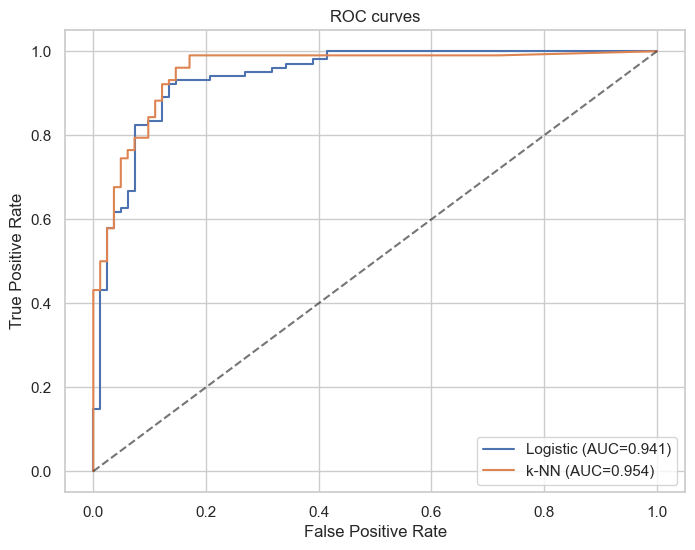

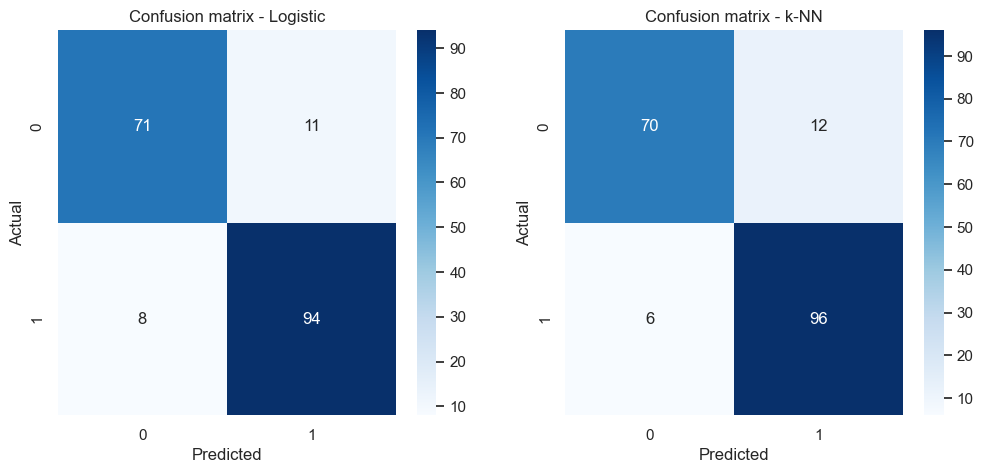

In [35]:
# Evaluación en test para ambos modelos
from sklearn.metrics import auc

def evaluate_model(model, X_test, y_test, name='model'):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # algunos clasificadores pueden no tener predict_proba
        y_proba = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"--- {name} ---")
    print('Accuracy:', round(acc,4))
    print('Precision:', round(prec,4))
    print('Recall:', round(rec,4))
    print('F1:', round(f1,4))
    print('ROC AUC:', round(roc_auc,4))
    print('\nClassification report:\n', classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    return {'y_pred': y_pred, 'y_proba': y_proba, 'cm': cm, 'metrics': (acc,prec,rec,f1,roc_auc)}

res_log = evaluate_model(best_log, X_test, y_test, name='LogisticRegression')
res_knn = evaluate_model(best_knn, X_test, y_test, name='k-NN')

# ROC curves ambos modelos
plt.figure(figsize=(8,6))
for res, label, color in [(res_log,'Logistic', 'C0'), (res_knn,'k-NN','C1')]:
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.3f})", color=color)

plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend()
plt.show()

# Matrices de confusión lado a lado
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(res_log['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion matrix - Logistic')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(res_knn['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion matrix - k-NN')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()


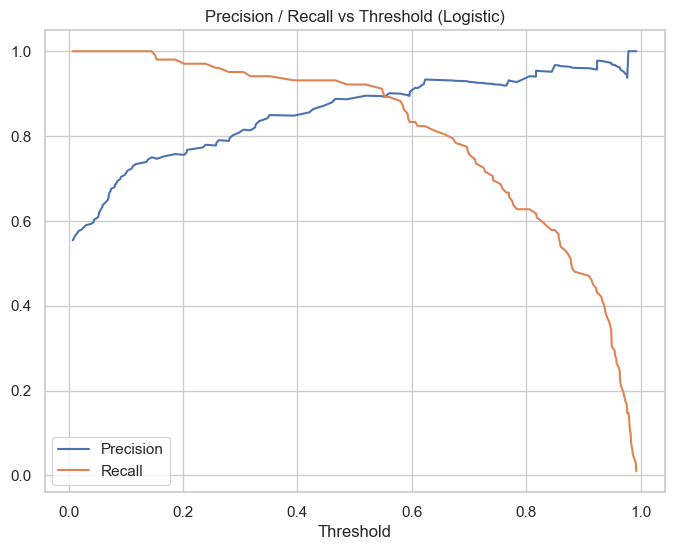


Threshold = 0.3
Accuracy: 0.8532608695652174
Precision: 0.8151260504201681
Recall: 0.9509803921568627
F1: 0.8778280542986425
Confusion matrix:
 [[60 22]
 [ 5 97]]

Threshold = 0.5
Accuracy: 0.8967391304347826
Precision: 0.8952380952380953
Recall: 0.9215686274509803
F1: 0.9082125603864735
Confusion matrix:
 [[71 11]
 [ 8 94]]

Threshold = 0.7
Accuracy: 0.8315217391304348
Precision: 0.927710843373494
Recall: 0.7549019607843137
F1: 0.8324324324324325
Confusion matrix:
 [[76  6]
 [25 77]]


In [36]:
# Threshold tuning (Precision-Recall) para el mejor modelo logistic (ejemplo)
from sklearn.metrics import precision_recall_curve

# Usar las probabilidades del logistic
y_scores = res_log['y_proba']
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision / Recall vs Threshold (Logistic)')
plt.show()

# Mostrar métricas para un umbral personalizado (ejemplo)
for thr in [0.3, 0.5, 0.7]:
    y_pred_thr = (y_scores >= thr).astype(int)
    print(f"\nThreshold = {thr}")
    print('Accuracy:', accuracy_score(y_test, y_pred_thr))
    print('Precision:', precision_score(y_test, y_pred_thr))
    print('Recall:', recall_score(y_test, y_pred_thr))
    print('F1:', f1_score(y_test, y_pred_thr))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_thr))


In [37]:
# Opción: aplicar SMOTE (si está disponible) y re-entrenar logistic para comparar
if IMBLEARN_AVAILABLE:
    print('imblearn disponible: aplicando SMOTE en pipeline')
    smote_pipe = ImbPipeline(steps=[
        ('preproc', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])

    param_grid_smote = {
        'clf__C': [0.01, 0.1, 1],
        'clf__class_weight': [None, 'balanced']
    }

    gs_smote = GridSearchCV(smote_pipe, param_grid_smote, cv=5, scoring='roc_auc', n_jobs=-1)
    gs_smote.fit(X_train, y_train)
    print('Mejores parámetros (SMOTE+Logistic):', gs_smote.best_params_)
    best_smote = gs_smote.best_estimator_
    res_smote = evaluate_model(best_smote, X_test, y_test, name='SMOTE+Logistic')
else:
    print('imblearn no está disponible en el entorno; se omite SMOTE (puede instalarse con pip install imbalanced-learn)')


imblearn no está disponible en el entorno; se omite SMOTE (puede instalarse con pip install imbalanced-learn)


,feature,coef,abs_coef
8,ChestPainType_ASY,1.262622,1.262622
19,ST_Slope_Up,-1.218283,1.218283
18,ST_Slope_Flat,0.930160,0.930160
7,Sex_M,0.721472,0.721472
6,Sex_F,-0.721367,0.721367
9,ChestPainType_ATA,-0.667171,0.667171
3,FastingBS,0.535177,0.535177
5,Oldpeak,0.362092,0.362092
10,ChestPainType_NAP,-0.342879,0.342879
16,ExerciseAngina_Y,0.294990,0.294990


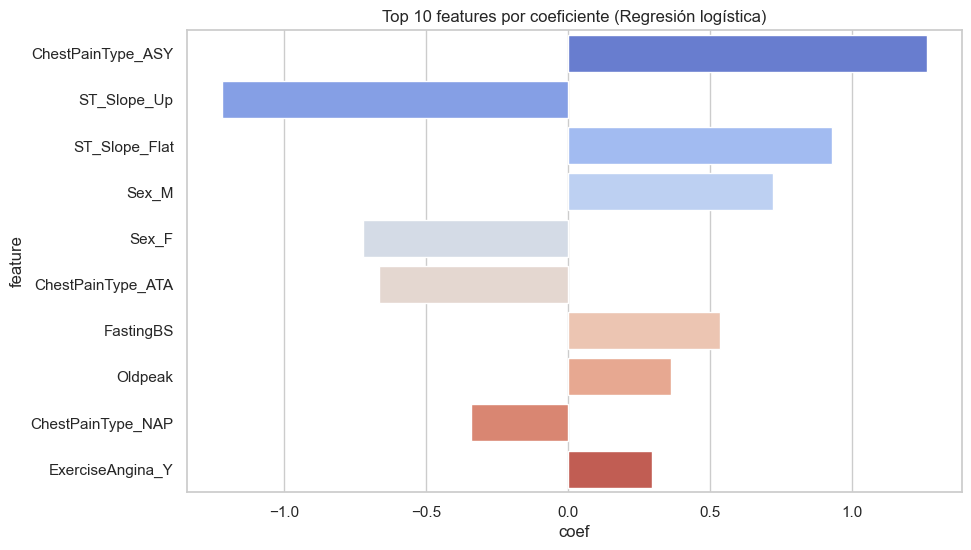

In [38]:
# Interpretación: coeficientes de la regresión logística
# Extraer nombres de features luego del preprocesamiento
pre = best_log.named_steps['preproc']
clf = best_log.named_steps['clf']

# nombres numéricos
num_names = numeric_features
cat_names = []
if len(categorical_features) > 0:
    try:
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        cat_ohe_names = list(ohe.get_feature_names_out(categorical_features))
        cat_names = cat_ohe_names
    except Exception:
        # fallback: usar categorías originales
        cat_names = categorical_features

feature_names = num_names + cat_names
coefs = clf.coef_.ravel()

feat_imp = pd.DataFrame({'feature': feature_names, 'coef': coefs})
feat_imp['abs_coef'] = feat_imp['coef'].abs()
feat_imp = feat_imp.sort_values('abs_coef', ascending=False)

display(feat_imp.head(20))

# Barplot de top 10
plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp.head(10), x='coef', y='feature', palette='coolwarm')
plt.title('Top 10 features por coeficiente (Regresión logística)')
plt.show()


In [39]:
# Guardar pipeline final y ejemplos de predicción
final_model = best_log  # escoger el modelo final; cambiar si prefiere otro
joblib.dump(final_model, 'heart_model_pipeline.joblib')
print('Modelo guardado en heart_model_pipeline.joblib')

# Ejemplo de cómo cargar y predecir
loaded = joblib.load('heart_model_pipeline.joblib')

sample = X_test.head(3).copy()
probs = loaded.predict_proba(sample)[:,1]
preds = loaded.predict(sample)

out = sample.copy()
out['pred_proba'] = probs
out['pred'] = preds

display(out)

# Guardar predicciones a csv
out_to_save = out.reset_index().rename(columns={'index':'row_index'})[['row_index'] + list(out.columns)]
out_to_save.to_csv('sample_predictions.csv', index=False)
print('Ejemplo de predicciones guardado en sample_predictions.csv')


Modelo guardado en heart_model_pipeline.joblib


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,pred_proba,pred
638,47,M,ASY,112.0,204.0,0,Normal,143.0,N,0.1,Up,0.286778,0
219,29,M,ATA,140.0,263.0,0,Normal,170.0,N,0.0,Up,0.044100,0
844,52,M,TA,118.0,186.0,0,LVH,190.0,N,0.0,Flat,0.317726,0


Ejemplo de predicciones guardado en sample_predictions.csv


## Conclusiones y siguientes pasos

- Implementamos la limpieza del dataset, tratando ceros no válidos como missing y aplicando imputación mediana para numéricos.
- Construimos pipelines reproducibles (preprocesamiento + estimador) y buscamos hiperparámetros para Regresión Logística y k-NN usando GridSearchCV.
- Reportamos métricas en test (accuracy, precision, recall, F1, ROC AUC), trazamos ROC y matrices de confusión, y exploramos ajuste de umbral para priorizar recall cuando necesario.
- Si hay desbalance marcado, SMOTE se aplicó opcionalmente (si la librería está disponible) y se compararon resultados.